<a href="https://colab.research.google.com/github/panda-sas/structflo-cser/blob/main/notebooks/01-quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# structflo-cser — Quickstart

This notebook walks through the **Chemical Structure + Label Extraction** pipeline
step-by-step, then shows the one-liner convenience API.

**Pipeline stages:**
1. **Detect** — YOLO finds chemical structures and compound labels
2. **Match** — Hungarian algorithm pairs each structure with its nearest label
3. **Extract** — DECIMER converts structure crops → SMILES; EasyOCR reads label text



## This notebook is opened from GitHub. To keep your edits, use File → Save a copy in Drive.

In [1]:
# Install lib
!pip install structflo-cser

In [5]:
# Load sample images
from pathlib import Path
import urllib.request

# Where to save it in the Colab runtime
out_path = Path("notebook-data/syn-1.jpg")
out_path.parent.mkdir(parents=True, exist_ok=True)

url = "https://raw.githubusercontent.com/structflo/structflo-cser/refs/heads/main/notebooks/notebook-data/syn-1.jpg"

# Download only if missing
if not out_path.exists():
    urllib.request.urlretrieve(url, out_path)

print("Saved to:", out_path, "exists:", out_path.exists(), "bytes:", out_path.stat().st_size)

Saved to: notebook-data/syn-1.jpg exists: True bytes: 71909


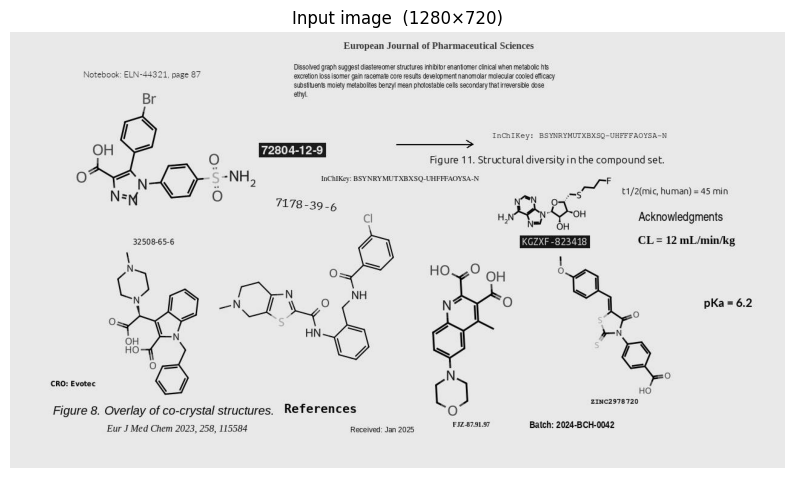

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

from structflo.cser.viz import plot_detections, plot_pairs, plot_crops, plot_results

# Choose a test image (change the filename as needed)
IMAGE_PATH = Path("notebook-data/syn-1.jpg")
assert IMAGE_PATH.exists(), f"Image not found: {IMAGE_PATH}"

img = Image.open(IMAGE_PATH).convert("RGB")
plt.figure(figsize=(10, 14))
plt.imshow(img)
plt.axis("off")
plt.title(f"Input image  ({img.width}×{img.height})")
plt.show()

## Part 1 — Step-by-step pipeline

### 1a. Create the pipeline

The pipeline is lazy — YOLO weights, DECIMER, and EasyOCR are only loaded on first use.

In [7]:
from structflo.cser.pipeline import ChemPipeline, HungarianMatcher

# Create pipeline — no tiling for this small demo image, match within 500px
pipeline = ChemPipeline(
    tile=False,
    conf=0.70,
    matcher=HungarianMatcher(max_distance=500),
)
print("Pipeline created (models not loaded yet)")

Pipeline created (models not loaded yet)


### 1b. Detect — find structures and labels

`pipeline.detect()` runs YOLO and returns a flat list of `Detection` objects (class 0 = structure, class 1 = label).

In [8]:
detections = pipeline.detect(IMAGE_PATH)

n_struct = sum(1 for d in detections if d.class_id == 0)
n_label  = sum(1 for d in detections if d.class_id == 1)
print(f"Found {n_struct} structures and {n_label} labels  ({len(detections)} total detections)")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


best.pt:   0%|          | 0.00/51.5M [00:00<?, ?B/s]

Found 6 structures and 6 labels  (12 total detections)


In [9]:
detections

[Detection(bbox=BBox(x1=903.9273071289062, y1=369.345458984375, x2=1093.782958984375, y2=598.6031494140625), conf=0.9719270467758179, class_id=0),
 Detection(bbox=BBox(x1=108.74500274658203, y1=99.41277313232422, x2=406.7509460449219, y2=288.47174072265625), conf=0.9706897735595703, class_id=0),
 Detection(bbox=BBox(x1=160.88973999023438, y1=362.9132080078125, x2=314.92987060546875, y2=599.71875), conf=0.9690966010093689, class_id=0),
 Detection(bbox=BBox(x1=805.428466796875, y1=239.84458923339844, x2=993.56689453125, y2=328.1633605957031), conf=0.9680100679397583, class_id=0),
 Detection(bbox=BBox(x1=342.84674072265625, y1=293.8406982421875, x2=637.3484497070312, y2=542.5748291015625), conf=0.9679995775222778, class_id=0),
 Detection(bbox=BBox(x1=406.0756530761719, y1=178.16477966308594, x2=526.3418579101562, y2=211.35562133789062), conf=0.9660992622375488, class_id=1),
 Detection(bbox=BBox(x1=836.9230346679688, y1=331.1315002441406, x2=962.1250610351562, y2=361.2911071777344), conf=0

### Visualise detections

Green = chemical structure, Blue = compound label.

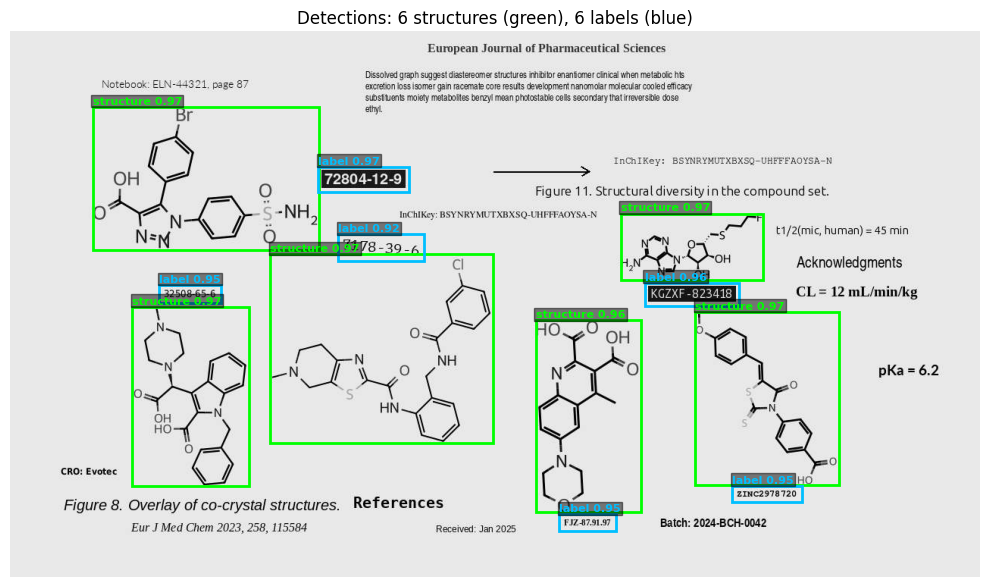

In [10]:
fig = plot_detections(img, detections)
plt.show()

### 1c. Match — pair structures with labels

`pipeline.match()` uses the Hungarian algorithm to optimally pair each structure with its nearest label by centroid distance.

In [11]:
pairs = pipeline.match(detections)
print(f"Matched {len(pairs)} structure–label pairs\n")

for i, p in enumerate(pairs):
    sc = p.structure.bbox.centroid
    lc = p.label.bbox.centroid
    print(f"  Pair {i}: distance={p.match_distance:.0f}px  "
          f"structure@({sc[0]:.0f},{sc[1]:.0f})  label@({lc[0]:.0f},{lc[1]:.0f})")

Matched 6 structure–label pairs

  Pair 0: distance=126px  structure@(999,484)  label@(999,610)
  Pair 1: distance=208px  structure@(258,194)  label@(466,195)
  Pair 2: distance=135px  structure@(238,481)  label@(237,346)
  Pair 3: distance=62px  structure@(899,284)  label@(900,346)
  Pair 4: distance=133px  structure@(490,418)  label@(490,285)
  Pair 5: distance=141px  structure@(763,507)  label@(762,648)


In [12]:
pairs

[CompoundPair(structure=Detection(bbox=BBox(x1=903.9273071289062, y1=369.345458984375, x2=1093.782958984375, y2=598.6031494140625), conf=0.9719270467758179, class_id=0), label=Detection(bbox=BBox(x1=952.542236328125, y1=599.04541015625, x2=1044.567138671875, y2=620.960693359375), conf=0.949870765209198, class_id=1), match_distance=126.02910568087141, smiles=None, label_text=None, match_confidence=None),
 CompoundPair(structure=Detection(bbox=BBox(x1=108.74500274658203, y1=99.41277313232422, x2=406.7509460449219, y2=288.47174072265625), conf=0.9706897735595703, class_id=0), label=Detection(bbox=BBox(x1=406.0756530761719, y1=178.16477966308594, x2=526.3418579101562, y2=211.35562133789062), conf=0.9660992622375488, class_id=1), match_distance=208.46238578561787, smiles=None, label_text=None, match_confidence=None),
 CompoundPair(structure=Detection(bbox=BBox(x1=160.88973999023438, y1=362.9132080078125, x2=314.92987060546875, y2=599.71875), conf=0.9690966010093689, class_id=0), label=Detec

### Visualise matched pairs

Orange lines connect each structure to its matched label.

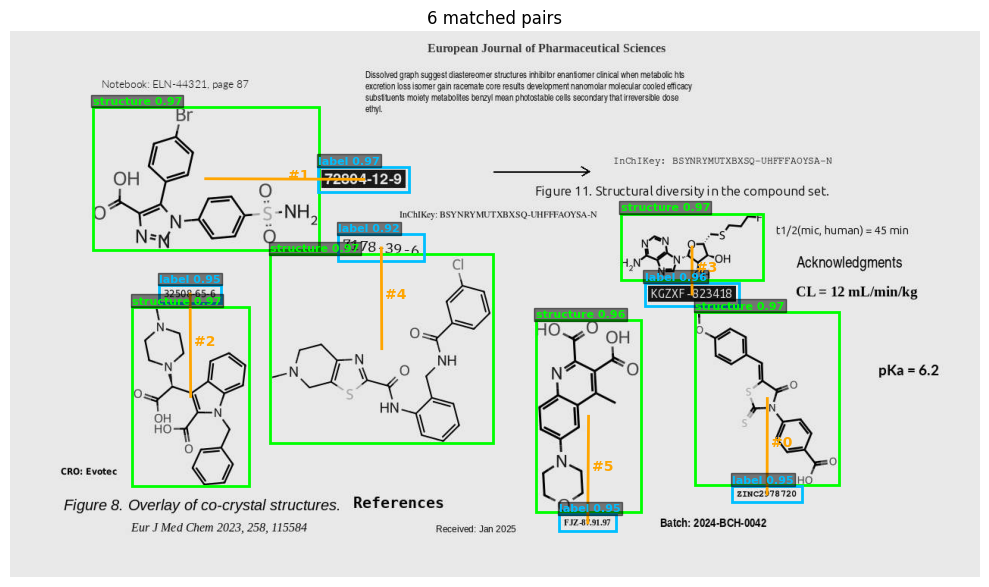

In [13]:
fig = plot_pairs(img, pairs)
plt.show()

### 1d. Show cropped regions for each pair

For each matched pair, we crop the structure and label regions from the original image.

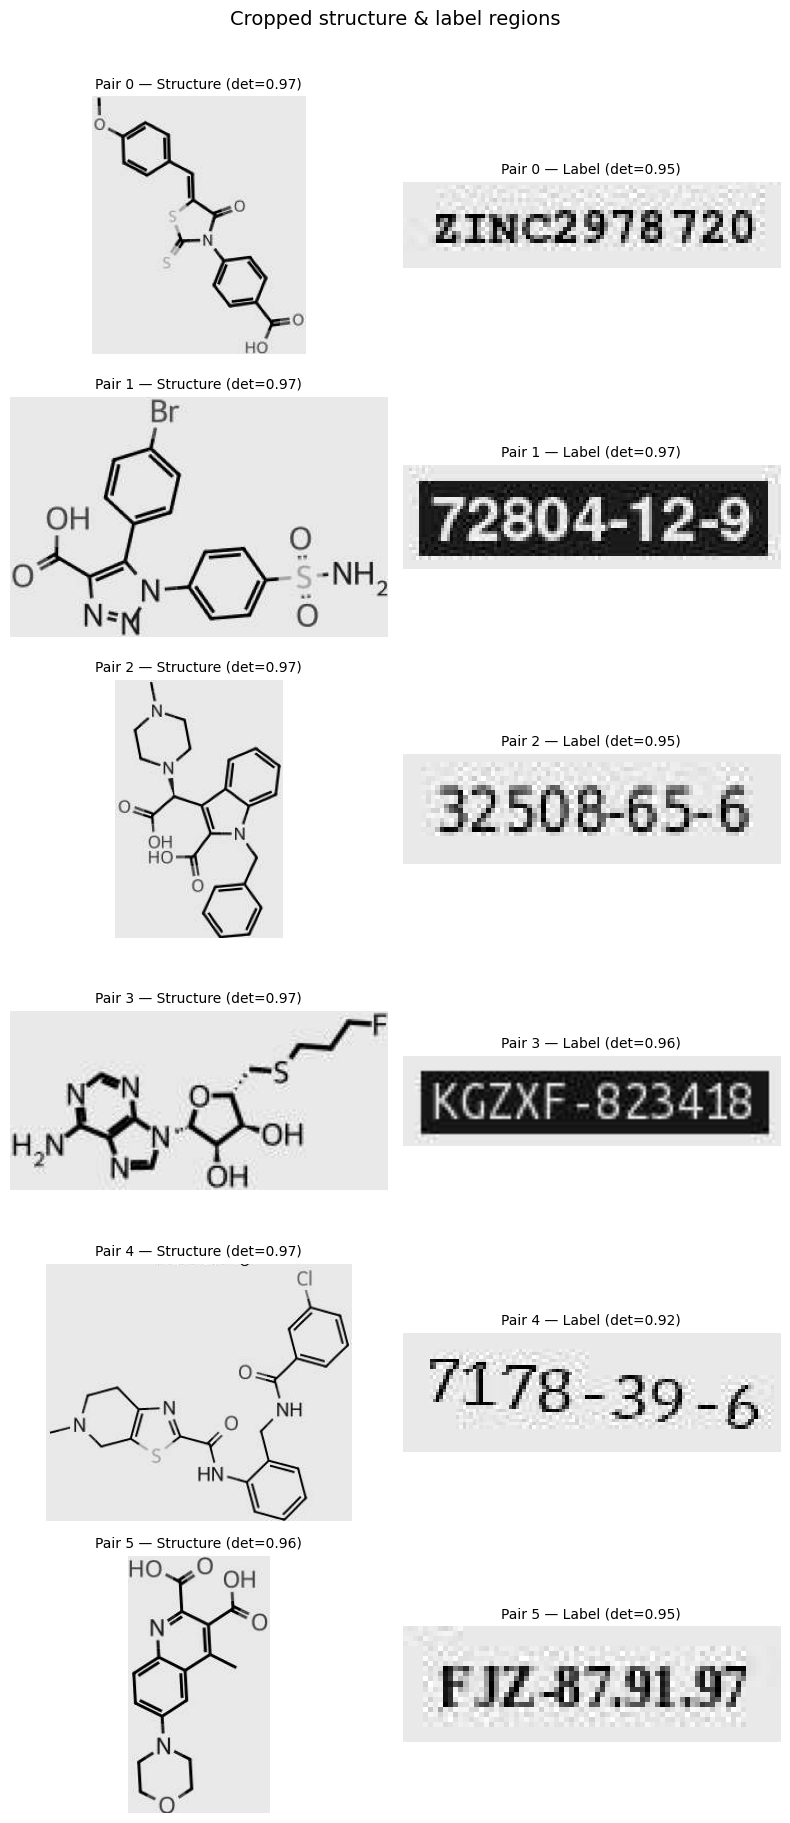

In [14]:
fig = plot_crops(img, pairs)
plt.show()

### 1e. Extract — SMILES and label text

`pipeline.enrich()` runs DECIMER on each structure crop and EasyOCR on each label crop, populating `pair.smiles` and `pair.label_text`.

In [15]:
enriched_pairs = pipeline.enrich(pairs, IMAGE_PATH)

for i, p in enumerate(enriched_pairs):
    print(f"Pair {i}:")
    print(f"  SMILES:     {p.smiles}")
    print(f"  Label text: {p.label_text}")
    print(f"  Distance:   {p.match_distance:.0f}px")
    print()

/root/.data/DECIMER-V2/models.zip
... done downloading trained model!


/root/.data/DECIMER-V2/DECIMER_HandDrawn_model.zip
... done downloading trained model!


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Pair 0:
  SMILES:     COC1=CC=C(C=C1)C=C2C(=O)N(C3=CC=C(C=C3)C(=O)O)C(=S)S2
  Label text: ZINC2978 720
  Distance:   126px

Pair 1:
  SMILES:     C1=CC(=CC=C1C2=C(C(=O)O)N=NN2C3=CC=C(C=C3)S(=O)(=O)N)Br
  Label text: 772804-12-9
  Distance:   208px

Pair 2:
  SMILES:     CN1CCN(CC1)[C@@H](C2=C(C(=O)O)N(CC3=CC=CC=C3)C4=CC=CC=C42)C(=O)O
  Label text: 32508-65-6
  Distance:   135px

Pair 3:
  SMILES:     C(CF)CSC[C@@H]1[C@H]([C@H]([C@H](N2C=NC3=C2N=CN=C3N)O1)O)O
  Label text: KGZXF -823418
  Distance:   62px

Pair 4:
  SMILES:     CN1CCC2=C(C1)SC(=N2)C(=O)NC3=C(C=CC=C3)CNC(=O)C4=CC=CC(=C4)Cl.[Y]
  Label text: 7178-39-6
  Distance:   133px

Pair 5:
  SMILES:     CC1=C(C(=NC2=CC=C(C=C12)N3CCOCC3)C(=O)O)C(=O)O
  Label text: FJZ 87.91.97
  Distance:   141px



### 1f. Results as a DataFrame

In [16]:
df = ChemPipeline.to_dataframe(enriched_pairs)
df

,structure_bbox,structure_conf,label_bbox,label_conf,match_distance,match_confidence,smiles,label_text
0,"[903.9273071289062, 369.345458984375, 1093.782...",0.9719,"[952.542236328125, 599.04541015625, 1044.56713...",0.9499,126.03,None,COC1=CC=C(C=C1)C=C2C(=O)N(C3=CC=C(C=C3)C(=O)O)...,ZINC2978 720
1,"[108.74500274658203, 99.41277313232422, 406.75...",0.9707,"[406.0756530761719, 178.16477966308594, 526.34...",0.9661,208.46,None,C1=CC(=CC=C1C2=C(C(=O)O)N=NN2C3=CC=C(C=C3)S(=O...,772804-12-9
2,"[160.88973999023438, 362.9132080078125, 314.92...",0.9691,"[196.052734375, 334.19134521484375, 278.330261...",0.9490,135.11,None,CN1CCN(CC1)[C@@H](C2=C(C(=O)O)N(CC3=CC=CC=C3)C...,32508-65-6
3,"[805.428466796875, 239.84458923339844, 993.566...",0.9680,"[836.9230346679688, 331.1315002441406, 962.125...",0.9632,62.21,None,C(CF)CSC[C@@H]1[C@H]([C@H]([C@H](N2C=NC3=C2N=C...,KGZXF -823418
4,"[342.84674072265625, 293.8406982421875, 637.34...",0.9680,"[432.846435546875, 267.3326110839844, 546.1672...",0.9245,132.97,None,CN1CCC2=C(C1)SC(=N2)C(=O)NC3=C(C=CC=C3)CNC(=O)...,7178-39-6
5,"[693.2688598632812, 380.8688049316406, 832.620...",0.9577,"[724.2098999023438, 636.9111328125, 799.659118...",0.9467,140.65,None,CC1=C(C(=NC2=CC=C(C=C12)N3CCOCC3)C(=O)O)C(=O)O,FJZ 87.91.97


---

## Part 2 — Full pipeline in one call

Everything above (detect → match → enrich) can be done in a single `process()` call.

In [17]:
from structflo.cser.pipeline import ChemPipeline, HungarianMatcher

# Create pipeline
pipeline = ChemPipeline(
    tile=False,
    conf=0.70,
    matcher=HungarianMatcher(max_distance=500),
)
print("Pipeline created (models not loaded yet)")

Pipeline created (models not loaded yet)


In [18]:
# One-liner: detect + match + extract SMILES & OCR in a single call
results = pipeline.process(IMAGE_PATH)

# View as DataFrame
ChemPipeline.to_dataframe(results)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


,structure_bbox,structure_conf,label_bbox,label_conf,match_distance,match_confidence,smiles,label_text
0,"[903.9273071289062, 369.345458984375, 1093.782...",0.9719,"[952.542236328125, 599.04541015625, 1044.56713...",0.9499,126.03,None,COC1=CC=C(C=C1)C=C2C(=O)N(C3=CC=C(C=C3)C(=O)O)...,ZINC2978 720
1,"[108.74500274658203, 99.41277313232422, 406.75...",0.9707,"[406.0756530761719, 178.16477966308594, 526.34...",0.9661,208.46,None,C1=CC(=CC=C1C2=C(C(=O)O)N=NN2C3=CC=C(C=C3)S(=O...,772804-12-9
2,"[160.88973999023438, 362.9132080078125, 314.92...",0.9691,"[196.052734375, 334.19134521484375, 278.330261...",0.9490,135.11,None,CN1CCN(CC1)[C@@H](C2=C(C(=O)O)N(CC3=CC=CC=C3)C...,32508-65-6
3,"[805.428466796875, 239.84458923339844, 993.566...",0.9680,"[836.9230346679688, 331.1315002441406, 962.125...",0.9632,62.21,None,C(CF)CSC[C@@H]1[C@H]([C@H]([C@H](N2C=NC3=C2N=C...,KGZXF -823418
4,"[342.84674072265625, 293.8406982421875, 637.34...",0.9680,"[432.846435546875, 267.3326110839844, 546.1672...",0.9245,132.97,None,CN1CCC2=C(C1)SC(=N2)C(=O)NC3=C(C=CC=C3)CNC(=O)...,7178-39-6
5,"[693.2688598632812, 380.8688049316406, 832.620...",0.9577,"[724.2098999023438, 636.9111328125, 799.659118...",0.9467,140.65,None,CC1=C(C(=NC2=CC=C(C=C12)N3CCOCC3)C(=O)O)C(=O)O,FJZ 87.91.97


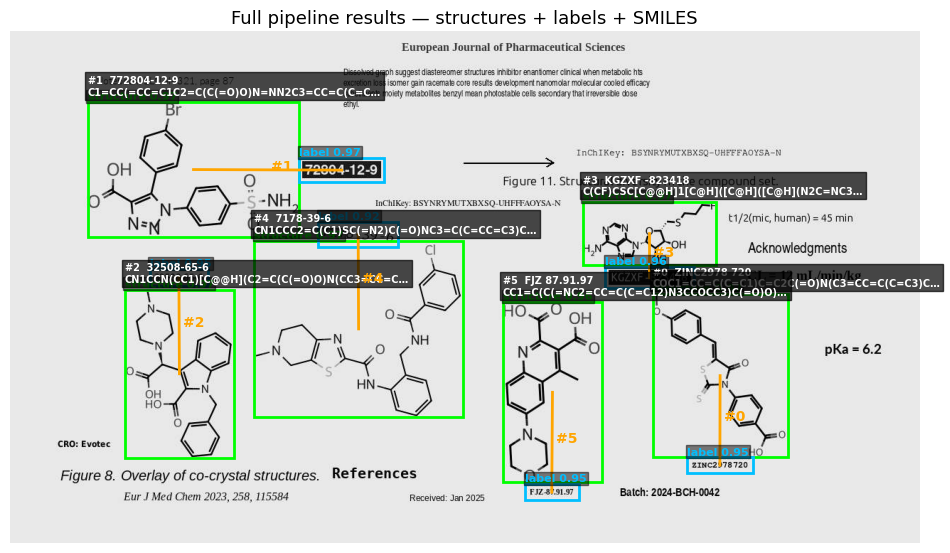

In [19]:
fig = plot_results(img, results)
plt.show()

### Export to JSON

In [20]:
print(ChemPipeline.to_json(results))

[
  {
    "structure_bbox": [
      903.9273071289062,
      369.345458984375,
      1093.782958984375,
      598.6031494140625
    ],
    "structure_conf": 0.9719,
    "label_bbox": [
      952.542236328125,
      599.04541015625,
      1044.567138671875,
      620.960693359375
    ],
    "label_conf": 0.9499,
    "match_distance": 126.03,
    "match_confidence": null,
    "smiles": "COC1=CC=C(C=C1)C=C2C(=O)N(C3=CC=C(C=C3)C(=O)O)C(=S)S2",
    "label_text": "ZINC2978 720"
  },
  {
    "structure_bbox": [
      108.74500274658203,
      99.41277313232422,
      406.7509460449219,
      288.47174072265625
    ],
    "structure_conf": 0.9707,
    "label_bbox": [
      406.0756530761719,
      178.16477966308594,
      526.3418579101562,
      211.35562133789062
    ],
    "label_conf": 0.9661,
    "match_distance": 208.46,
    "match_confidence": null,
    "smiles": "C1=CC(=CC=C1C2=C(C(=O)O)N=NN2C3=CC=C(C=C3)S(=O)(=O)N)Br",
    "label_text": "772804-12-9"
  },
  {
    "structure_bbox": [


### Final annotated image with extracted info

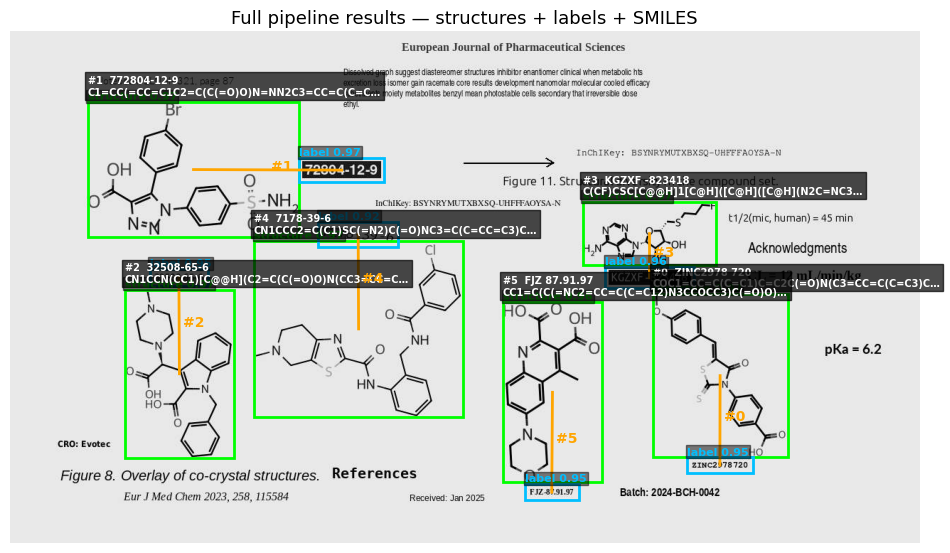

In [21]:
fig = plot_results(img, results)
plt.show()